In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [14]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        
        img = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor([class_id])
        
        return {'img': t_img, 'label': t_class_id}
        

In [15]:
train_dogs_path = 'training_set/training_set/dogs'
train_cats_path = 'training_set/training_set/cats'
test_dogs_path = 'test_set/test_set/dogs'
test_cats_path = 'test_set/test_set/cats'

train_ds_catsdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catsdogs = Dataset2class(test_dogs_path, test_cats_path)

In [16]:
print(f'Train size: {len(train_ds_catsdogs)}')
print(f'Test size: {len(test_ds_catsdogs)}')

Train size: 8005
Test size: 2023


In [17]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, 
    batch_size=batch_size, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds_catsdogs, shuffle=False,
    batch_size=batch_size, drop_last=False
)

In [18]:
class VGG13(nn.Module):
    def __init__(self, out_nc):
        super().__init__()
        
        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))       
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, out_nc)
        
    def forward(self, x):
        out = self.conv1_1(x)
        out = self.act(out)
        out = self.conv1_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv2_1(out)
        out = self.act(out)
        out = self.conv2_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv3_1(out)
        out = self.act(out)
        out = self.conv3_2(out)
        out = self.act(out)
        out = self.conv3_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv4_1(out)
        out = self.act(out)
        out = self.conv4_2(out)
        out = self.act(out)
        out = self.conv4_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        out = self.avgpool(out)
        out = self.flat(out)
        
        out = self.fc1(out)
        out = self.act(out)
        out = self.fc3(out)
        
        return out

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy(pred, label):
    answer = (F.sigmoid(pred.detach().cpu()).numpy() > 0.5) == (label.cpu().numpy() > 0.5)
    return answer.mean()


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = VGG13(1) 
model = model.to(device)
count_parameters(model)

epochs = 10


loss_fn = nn.BCEWithLogitsLoss()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    print(f'epoch {epoch+1}')
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        img = img.to(device)
        label = label.float().to(device)
        optimizer.zero_grad()

        pred = model(img)
        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

0.6921591918468475
0.516625
epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

0.6841092257499695
0.562
epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

0.6682463564872742
0.60225
epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

0.6446272931694984
0.630875
epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

0.6179212157726288
0.663625
epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

0.5877389267086983
0.69425
epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

0.562645715713501
0.714
epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

0.5403142029643059
0.731
epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

0.5273479379117488
0.7425
epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

0.5056063162386417
0.75


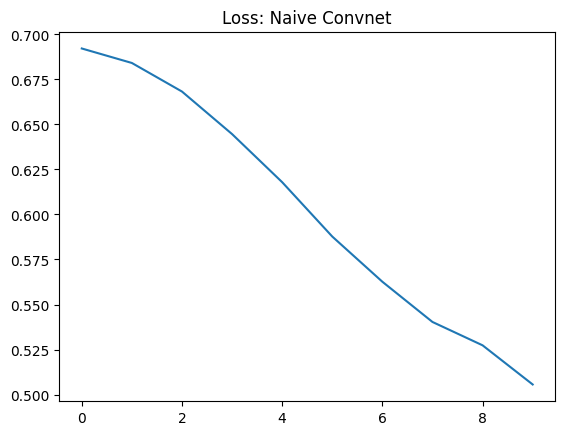

In [23]:
plt.title('Loss: Naive Convnet')
plt.plot(loss_epochs_list)

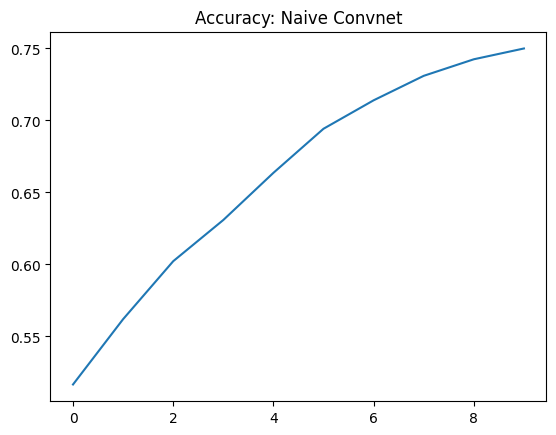

In [24]:
plt.title('Accuracy: Naive Convnet')
plt.plot(acc_epochs_list)